# 02.7 - Weather Data Exploration

This notebook explores the WEATHER data from FastF1, focusing on:
- Understanding data structure and columns
- Comparing datasets across years for consistency
- Validating data completeness (events, sessions, coverage)
- Identifying features for extraction
- Checking year-over-year consistency in row counts, data quality, and coverage

## Goals:
- Understand the structure of WEATHER data
- Identify available columns and data types
- Compare row counts across years
- Validate data completeness and consistency
- Prepare for feature extraction


In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import warnings
import sys
warnings.filterwarnings('ignore')

# Set up paths
PROJECT_ROOT = Path(r"C:\Users\erikv\Downloads\F1")
FASTF1_ROOT = PROJECT_ROOT / "data" / "raw" / "fastf1_2018plus"

print(f"FastF1 data: {FASTF1_ROOT}")
print(f"Python version: {sys.version}")
print(f"Pandas version: {pd.__version__}")


FastF1 data: C:\Users\erikv\Downloads\F1\data\raw\fastf1_2018plus
Python version: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
Pandas version: 2.3.3


## 1. File Size Analysis
Check the size of all WEATHER files to understand data volume.


In [2]:
# Check file sizes for all weather files
weather_files = sorted(FASTF1_ROOT.glob("ALL_WEATHER_*.csv"))

print("WEATHER File Sizes:")
print("=" * 60)

total_size = 0
file_sizes_by_year = {}
for file_path in weather_files:
    year = file_path.stem.split('_')[-1]
    size_mb = file_path.stat().st_size / (1024 * 1024)
    size_gb = size_mb / 1024
    total_size += size_mb
    file_sizes_by_year[year] = size_mb
    
    print(f"{file_path.name:30s} {size_mb:>10.2f} MB ({size_gb:>6.3f} GB)")

print("=" * 60)
print(f"{'Total':30s} {total_size:>10.2f} MB ({total_size/1024:>6.3f} GB)")
print(f"\nNumber of files: {len(weather_files)}")


WEATHER File Sizes:
ALL_WEATHER_2018.csv                 0.81 MB ( 0.001 GB)
ALL_WEATHER_2019.csv                 0.67 MB ( 0.001 GB)
ALL_WEATHER_2020.csv                 0.65 MB ( 0.001 GB)
ALL_WEATHER_2021.csv                 0.89 MB ( 0.001 GB)
ALL_WEATHER_2022.csv                 0.95 MB ( 0.001 GB)
ALL_WEATHER_2023.csv                 0.89 MB ( 0.001 GB)
ALL_WEATHER_2024.csv                 0.93 MB ( 0.001 GB)
Total                                5.78 MB ( 0.006 GB)

Number of files: 7


## 2. Column Discovery and Data Structure
Explore the structure of weather data.


In [3]:
# Load a sample from first file to understand structure
test_file = weather_files[0] if weather_files else None

if test_file:
    print(f"Analyzing structure of: {test_file.name}")
    print("=" * 60)
    
    # Read first few rows
    sample_df = pd.read_csv(test_file, nrows=100)
    
    print(f"\nColumns ({len(sample_df.columns)}):")
    for i, col in enumerate(sample_df.columns, 1):
        dtype = sample_df[col].dtype
        null_pct = (sample_df[col].isnull().sum() / len(sample_df)) * 100
        print(f"  {i:2d}. {col:30s} {str(dtype):15s} {null_pct:5.1f}% null")
    
    print(f"\nData types:")
    print(sample_df.dtypes)
    
    print(f"\nMemory usage: {sample_df.memory_usage(deep=True).sum() / (1024 * 1024):.2f} MB (for 100 rows)")
    
    print(f"\nSample data (first 5 rows):")
    print(sample_df.head())
    
    print(f"\nData summary:")
    print(sample_df.describe(include='all'))


Analyzing structure of: ALL_WEATHER_2018.csv

Columns (11):
   1. Time                           object            0.0% null
   2. AirTemp                        float64           0.0% null
   3. Humidity                       float64           0.0% null
   4. Pressure                       float64           0.0% null
   5. Rainfall                       bool              0.0% null
   6. TrackTemp                      float64           0.0% null
   7. WindDirection                  int64             0.0% null
   8. WindSpeed                      float64           0.0% null
   9. Year                           int64             0.0% null
  10. Event                          object            0.0% null
  11. Session                        object            0.0% null

Data types:
Time              object
AirTemp          float64
Humidity         float64
Pressure         float64
Rainfall            bool
TrackTemp        float64
WindDirection      int64
WindSpeed        float64
Year        

## 3. Row Count Comparison Across Years
Compare row counts for all weather files across different years to understand data volume trends and consistency.


In [4]:
# Count rows for all weather files
print("Row Count Comparison by Year:")
print("=" * 70)

row_counts_by_year = {}

for file_path in weather_files:
    year = file_path.stem.split('_')[-1]
    file_size_mb = file_sizes_by_year[year]
    
    print(f"\n{year}: {file_path.name}")
    print(f"  File size: {file_size_mb:.2f} MB")
    print(f"  Counting rows...")
    
    try:
        df = pd.read_csv(file_path)
        row_count = len(df)
        row_counts_by_year[year] = row_count
        
        print(f"  ✓ Total rows: {row_count:,}")
        
        # Calculate rows per MB
        rows_per_mb = row_count / file_size_mb if file_size_mb > 0 else 0
        print(f"  ✓ Rows per MB: {rows_per_mb:,.0f}")
        
        # Clear from memory
        del df
    except Exception as e:
        print(f"  ✗ Error: {e}")

print("\n" + "=" * 70)
print("SUMMARY - Row Counts by Year:")
print("=" * 70)

# Create comparison DataFrame
if row_counts_by_year:
    comparison_df = pd.DataFrame({
        'Year': list(row_counts_by_year.keys()),
        'Row_Count': list(row_counts_by_year.values()),
        'File_Size_MB': [file_sizes_by_year.get(year, 0) for year in row_counts_by_year.keys()]
    })
    
    # Sort by year
    comparison_df = comparison_df.sort_values('Year')
    
    # Calculate additional metrics
    comparison_df['Rows_Per_MB'] = comparison_df['Row_Count'] / comparison_df['File_Size_MB']
    comparison_df['Pct_of_Total'] = (comparison_df['Row_Count'] / comparison_df['Row_Count'].sum() * 100).round(2)
    
    # Display formatted table
    print(f"\n{'Year':<8} {'Row Count':>15} {'File Size (MB)':>18} {'Rows/MB':>12} {'% of Total':>12}")
    print("-" * 70)
    
    for _, row in comparison_df.iterrows():
        print(f"{row['Year']:<8} {row['Row_Count']:>15,} {row['File_Size_MB']:>18,.2f} "
              f"{row['Rows_Per_MB']:>12,.0f} {row['Pct_of_Total']:>11.2f}%")
    
    print("-" * 70)
    print(f"{'TOTAL':<8} {comparison_df['Row_Count'].sum():>15,} {comparison_df['File_Size_MB'].sum():>18,.2f} "
          f"{comparison_df['Row_Count'].sum() / comparison_df['File_Size_MB'].sum():>12,.0f} {'100.00':>12}%")
    
    # Find min/max
    max_year = comparison_df.loc[comparison_df['Row_Count'].idxmax(), 'Year']
    max_rows = comparison_df['Row_Count'].max()
    min_year = comparison_df.loc[comparison_df['Row_Count'].idxmin(), 'Year']
    min_rows = comparison_df['Row_Count'].min()
    
    print(f"\nMaximum rows: {max_year} with {max_rows:,} rows")
    print(f"Minimum rows: {min_year} with {min_rows:,} rows")
    print(f"Range: {max_rows - min_rows:,} rows ({((max_rows / min_rows - 1) * 100):.1f}% difference)")
    
    # Check for consistency
    median_rows = comparison_df['Row_Count'].median()
    std_rows = comparison_df['Row_Count'].std()
    cv = (std_rows / median_rows * 100) if median_rows > 0 else 0
    
    print(f"\nConsistency check:")
    print(f"  Median rows: {median_rows:,.0f}")
    print(f"  Standard deviation: {std_rows:,.0f}")
    print(f"  Coefficient of variation: {cv:.1f}%")
    
    if cv > 30:
        print(f"  ⚠️  High variation detected - may indicate data completeness issues")
    elif cv > 15:
        print(f"  ⚠️  Moderate variation - check for missing events or sessions")
    else:
        print(f"  ✓ Low variation - data appears consistent across years")
    
    # Store for later use
    weather_row_counts = comparison_df
else:
    print("No row counts available")
    weather_row_counts = None


Row Count Comparison by Year:

2018: ALL_WEATHER_2018.csv
  File size: 0.81 MB
  Counting rows...
  ✓ Total rows: 9,707
  ✓ Rows per MB: 11,995

2019: ALL_WEATHER_2019.csv
  File size: 0.67 MB
  Counting rows...
  ✓ Total rows: 8,077
  ✓ Rows per MB: 12,075

2020: ALL_WEATHER_2020.csv
  File size: 0.65 MB
  Counting rows...
  ✓ Total rows: 7,822
  ✓ Rows per MB: 12,043

2021: ALL_WEATHER_2021.csv
  File size: 0.89 MB
  Counting rows...
  ✓ Total rows: 10,616
  ✓ Rows per MB: 11,969

2022: ALL_WEATHER_2022.csv
  File size: 0.95 MB
  Counting rows...
  ✓ Total rows: 11,285
  ✓ Rows per MB: 11,937

2023: ALL_WEATHER_2023.csv
  File size: 0.89 MB
  Counting rows...
  ✓ Total rows: 10,613
  ✓ Rows per MB: 11,953

2024: ALL_WEATHER_2024.csv
  File size: 0.93 MB
  Counting rows...
  ✓ Total rows: 11,127
  ✓ Rows per MB: 11,926

SUMMARY - Row Counts by Year:

Year           Row Count     File Size (MB)      Rows/MB   % of Total
------------------------------------------------------------------

In [5]:
# Expected races per year (from known F1 calendar)
expected_races = {
    '2018': 21,
    '2019': 21,
    '2020': 17,  # COVID-19 shortened season
    '2021': 22,
    '2022': 22,
    '2023': 22,
    '2024': 24
}

# Expected sessions per race (typically: FP1, FP2, FP3, Q, R)
expected_sessions_per_race = 5

print("Data Completeness Validation:")
print("=" * 80)

# Extract unique events and sessions from weather data
weather_coverage = {}

for file_path in weather_files:
    year = file_path.stem.split('_')[-1]
    print(f"\n{year}: Analyzing coverage...")
    
    try:
        df = pd.read_csv(file_path)
        
        unique_events = df['Event'].unique() if 'Event' in df.columns else []
        unique_sessions = df['Session'].unique() if 'Session' in df.columns else []
        
        # Count unique event-session combinations
        if 'Event' in df.columns and 'Session' in df.columns:
            event_session_counts = df.groupby(['Event', 'Session']).size()
            unique_combinations = len(event_session_counts)
        else:
            unique_combinations = 0
        
        weather_coverage[year] = {
            'unique_events': len(unique_events),
            'unique_sessions': len(unique_sessions),
            'events': sorted(unique_events),
            'sessions': sorted(unique_sessions),
            'event_session_combinations': unique_combinations,
            'total_rows': len(df)
        }
        
        print(f"  Found {len(unique_events)} unique events")
        print(f"  Found {len(unique_sessions)} unique sessions: {sorted(unique_sessions)}")
        print(f"  Found {unique_combinations} unique event-session combinations")
        print(f"  Total rows: {len(df):,}")
        
        # Clear from memory
        del df
        
    except Exception as e:
        print(f"  Error: {e}")
        weather_coverage[year] = None

# Validation: Compare against expected
print("\n" + "=" * 80)
print("COMPLETENESS CHECK:")
print("=" * 80)

print(f"\n{'Year':<8} {'Expected Races':>15} {'Found Events':>15} {'Difference':>12} {'Status':>15}")
print("-" * 80)

completeness_issues = []

for year in sorted(weather_coverage.keys()):
    if weather_coverage[year] is None:
        continue
    
    found_events = weather_coverage[year]['unique_events']
    expected = expected_races.get(year, 0)
    diff = found_events - expected
    
    if expected > 0:
        if diff == 0:
            status = "✓ Complete"
        elif diff < 0:
            status = f"⚠ Missing {abs(diff)}"
            completeness_issues.append({
                'year': year,
                'issue': f"Missing {abs(diff)} race(s). Expected {expected}, found {found_events}"
            })
        else:
            status = f"+{diff} extra"
    else:
        status = "? Unknown"
    
    print(f"{year:<8} {expected:>15} {found_events:>15} {diff:>+12} {status:>15}")

# Calculate rows per race (normalized)
print("\n" + "=" * 80)
print("ROWS PER RACE (Normalized for comparison):")
print("=" * 80)

print(f"\n{'Year':<8} {'Total Rows':>15} {'Events Found':>15} {'Rows/Race':>15} {'Relative':>12}")
print("-" * 80)

rows_per_race_by_year = {}

for year in sorted(weather_coverage.keys()):
    if weather_coverage[year] is None:
        continue
    
    total_rows = weather_coverage[year]['total_rows']
    events = weather_coverage[year]['unique_events']
    
    if events > 0:
        rows_per_race = total_rows / events
        rows_per_race_by_year[year] = rows_per_race
        
        # Calculate relative to median for comparison
        if len(rows_per_race_by_year) > 1:
            median_rpr = np.median(list(rows_per_race_by_year.values()))
            relative = (rows_per_race / median_rpr * 100) if median_rpr > 0 else 100
        else:
            relative = 100
        
        print(f"{year:<8} {total_rows:>15,} {events:>15} {rows_per_race:>15,.0f} {relative:>11.0f}%")

# Flag significant variations
if len(rows_per_race_by_year) > 1:
    median_rpr = np.median(list(rows_per_race_by_year.values()))
    std_rpr = np.std(list(rows_per_race_by_year.values()))
    
    print("\n⚠️  VARIATION ANALYSIS:")
    for year in sorted(rows_per_race_by_year.keys()):
        rpr = rows_per_race_by_year[year]
        deviation = abs(rpr - median_rpr) / median_rpr * 100 if median_rpr > 0 else 0
        
        if deviation > 30:  # More than 30% deviation
            print(f"  {year}: {deviation:.1f}% deviation from median ({median_rpr:.0f} rows/race)")
            print(f"    Possible causes: Different sampling frequency, missing sessions, or data quality issues")
        elif deviation > 15:
            print(f"  {year}: {deviation:.1f}% deviation (moderate - may be normal variation)")

# Summary of issues
if completeness_issues:
    print("\n" + "=" * 80)
    print("⚠️  DATA COMPLETENESS ISSUES DETECTED:")
    print("=" * 80)
    for issue in completeness_issues:
        print(f"  {issue['year']}: {issue['issue']}")
else:
    print("\n✅ No major completeness issues detected in event coverage.")
    print("   Row count variations likely due to:")
    print("   - Different number of races per year (normal)")
    print("   - Different session lengths (normal)")
    print("   - Different weather sampling frequencies (possible)")


Data Completeness Validation:

2018: Analyzing coverage...
  Found 21 unique events
  Found 5 unique sessions: ['FP1', 'FP2', 'FP3', 'Q', 'R']
  Found 105 unique event-session combinations
  Total rows: 9,707

2019: Analyzing coverage...
  Found 16 unique events
  Found 5 unique sessions: ['FP1', 'FP2', 'FP3', 'Q', 'R']
  Found 80 unique event-session combinations
  Total rows: 8,077

2020: Analyzing coverage...
  Found 15 unique events
  Found 5 unique sessions: ['FP1', 'FP2', 'FP3', 'Q', 'R']
  Found 72 unique event-session combinations
  Total rows: 7,822

2021: Analyzing coverage...
  Found 22 unique events
  Found 6 unique sessions: ['FP1', 'FP2', 'FP3', 'Q', 'R', 'Sprint']
  Found 110 unique event-session combinations
  Total rows: 10,616

2022: Analyzing coverage...
  Found 22 unique events
  Found 6 unique sessions: ['FP1', 'FP2', 'FP3', 'Q', 'R', 'Sprint']
  Found 110 unique event-session combinations
  Total rows: 11,285

2023: Analyzing coverage...
  Found 22 unique events
 

In [6]:
# Analyze weather features across years
print("Weather Feature Analysis:")
print("=" * 80)

# Sample from each year to check feature consistency
feature_summary = {}

for file_path in weather_files:
    year = file_path.stem.split('_')[-1]
    print(f"\n{year}: Analyzing features...")
    
    try:
        df = pd.read_csv(file_path)
        
        # Numeric columns summary
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        
        # Exclude Year if it's numeric
        if 'Year' in numeric_cols:
            numeric_cols.remove('Year')
        
        feature_summary[year] = {}
        
        print(f"  Numeric features: {numeric_cols}")
        
        for col in numeric_cols:
            if col in df.columns:
                feature_summary[year][col] = {
                    'mean': df[col].mean(),
                    'std': df[col].std(),
                    'min': df[col].min(),
                    'max': df[col].max(),
                    'null_pct': (df[col].isnull().sum() / len(df)) * 100
                }
                print(f"    {col}: mean={df[col].mean():.2f}, std={df[col].std():.2f}, "
                      f"range=[{df[col].min():.2f}, {df[col].max():.2f}], "
                      f"null={feature_summary[year][col]['null_pct']:.1f}%")
        
        # Categorical columns
        categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()
        if 'Year' in categorical_cols:
            categorical_cols.remove('Year')
        if 'Event' in categorical_cols:
            categorical_cols.remove('Event')
        if 'Session' in categorical_cols:
            categorical_cols.remove('Session')
        
        print(f"  Categorical features: {categorical_cols}")
        for col in categorical_cols:
            if col in df.columns:
                unique_count = df[col].nunique()
                print(f"    {col}: {unique_count} unique values")
        
        del df
        
    except Exception as e:
        print(f"  Error: {e}")

# Cross-year consistency check
print("\n" + "=" * 80)
print("CROSS-YEAR CONSISTENCY CHECK:")
print("=" * 80)

if feature_summary:
    # Check if all years have same features
    all_features = set()
    for year_data in feature_summary.values():
        all_features.update(year_data.keys())
    
    print(f"\nAll numeric features found: {sorted(all_features)}")
    
    # Check consistency of feature ranges
    print("\nFeature range consistency:")
    for feature in sorted(all_features):
        print(f"\n  {feature}:")
        years_with_feature = [y for y in feature_summary.keys() if feature in feature_summary[y]]
        
        if len(years_with_feature) < len(feature_summary):
            missing_years = set(feature_summary.keys()) - set(years_with_feature)
            print(f"    ⚠️  Missing in years: {sorted(missing_years)}")
        else:
            means = [feature_summary[y][feature]['mean'] for y in years_with_feature]
            stds = [feature_summary[y][feature]['std'] for y in years_with_feature]
            
            mean_of_means = np.mean(means)
            std_of_means = np.std(means)
            
            print(f"    Mean across years: {mean_of_means:.2f} (std: {std_of_means:.2f})")
            
            if std_of_means / mean_of_means > 0.5:  # High variation
                print(f"    ⚠️  High variation in means across years")
            
            # Check for outliers
            for year in years_with_feature:
                year_mean = feature_summary[year][feature]['mean']
                z_score = abs(year_mean - mean_of_means) / std_of_means if std_of_means > 0 else 0
                if z_score > 2:
                    print(f"    ⚠️  {year}: Outlier (z-score: {z_score:.2f})")


Weather Feature Analysis:

2018: Analyzing features...
  Numeric features: ['AirTemp', 'Humidity', 'Pressure', 'TrackTemp', 'WindDirection', 'WindSpeed']
    AirTemp: mean=23.34, std=4.65, range=[11.60, 34.90], null=0.0%
    Humidity: mean=55.68, std=18.25, range=[0.00, 95.20], null=0.0%
    Pressure: mean=984.93, std=54.31, range=[779.30, 1022.30], null=0.0%
    TrackTemp: mean=33.93, std=8.67, range=[14.80, 59.00], null=0.0%
    WindDirection: mean=177.37, std=105.68, range=[-180.00, 359.00], null=0.0%
    WindSpeed: mean=1.70, std=0.94, range=[0.00, 8.00], null=0.0%
  Categorical features: ['Time', 'Rainfall']
    Time: 9704 unique values
    Rainfall: 2 unique values

2019: Analyzing features...
  Numeric features: ['AirTemp', 'Humidity', 'Pressure', 'TrackTemp', 'WindDirection', 'WindSpeed']
    AirTemp: mean=23.54, std=4.58, range=[14.60, 38.60], null=0.0%
    Humidity: mean=52.17, std=15.91, range=[12.90, 90.30], null=0.0%
    Pressure: mean=998.80, std=22.30, range=[940.40, 102

## 6. Visualization (Optional)
Visualize row counts and data distribution if matplotlib is available.


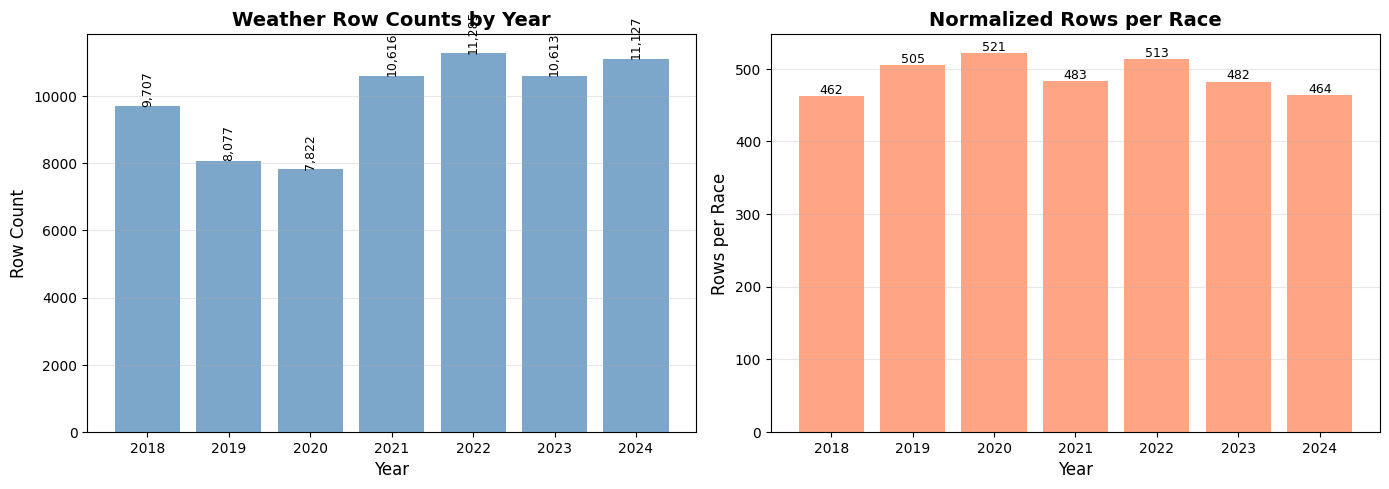

Visualization created successfully!


In [7]:
# Optional: Visualize row counts comparison (if matplotlib is available)
try:
    import matplotlib.pyplot as plt
    
    if weather_row_counts is not None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot 1: Row counts by year
        ax1.bar(weather_row_counts['Year'].astype(str), weather_row_counts['Row_Count'], 
                color='steelblue', alpha=0.7)
        ax1.set_xlabel('Year', fontsize=12)
        ax1.set_ylabel('Row Count', fontsize=12)
        ax1.set_title('Weather Row Counts by Year', fontsize=14, fontweight='bold')
        ax1.grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for idx, row in weather_row_counts.iterrows():
            height = row['Row_Count']
            ax1.text(row['Year'], height, f'{height:,.0f}', 
                    ha='center', va='bottom', fontsize=9, rotation=90)
        
        # Plot 2: Rows per race (normalized)
        if rows_per_race_by_year:
            years = sorted(rows_per_race_by_year.keys())
            rpr_values = [rows_per_race_by_year[y] for y in years]
            
            ax2.bar([str(y) for y in years], rpr_values, color='coral', alpha=0.7)
            ax2.set_xlabel('Year', fontsize=12)
            ax2.set_ylabel('Rows per Race', fontsize=12)
            ax2.set_title('Normalized Rows per Race', fontsize=14, fontweight='bold')
            ax2.grid(axis='y', alpha=0.3)
            
            # Add value labels
            for year, value in zip(years, rpr_values):
                ax2.text(str(year), value, f'{value:,.0f}', 
                        ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout()
        plt.show()
        
        print("Visualization created successfully!")
    else:
        print("No data available for visualization")
        
except ImportError:
    print("Matplotlib not available - skipping visualization")
except Exception as e:
    print(f"Error creating visualization: {e}")


## 7. Summary and Feature Extraction Recommendations
Summarize findings and recommend features for extraction.


In [8]:
print("WEATHER DATA SUMMARY AND RECOMMENDATIONS")
print("=" * 80)

print("\n1. AVAILABLE FEATURES:")
print("-" * 80)
if test_file:
    sample = pd.read_csv(test_file, nrows=1)
    print("Columns available:")
    for col in sample.columns:
        print(f"  - {col}")

print("\n2. POTENTIAL FEATURES FOR EXTRACTION:")
print("-" * 80)
print("Based on analysis, recommended features:")
print("  - Time-based: Time, SessionTime")
print("  - Temperature: AirTemp, TrackTemp")
print("  - Atmospheric: Humidity, Pressure, WindDirection, WindSpeed")
print("  - Conditions: Rainfall (boolean)")
print("  - Context: Year, Event, Session")
print("  - Derived: Temperature delta (TrackTemp - AirTemp), Wind components")

print("\n3. DATA QUALITY:")
print("-" * 80)
if completeness_issues:
    print("  ⚠️  Issues found - review completeness section above")
else:
    print("  ✓ No major data quality issues detected")

if weather_row_counts is not None:
    cv = (weather_row_counts['Row_Count'].std() / weather_row_counts['Row_Count'].mean() * 100)
    print(f"  Consistency (CV): {cv:.1f}%")
    if cv > 30:
        print("  ⚠️  High variation - investigate specific years")

print("\n4. FEATURE EXTRACTION STRATEGY:")
print("-" * 80)
print("  - Group by: Year, Event, Session")
print("  - Aggregate: Mean, Min, Max, Std for numeric features")
print("  - Flag conditions: Rain events, extreme temperatures")
print("  - Time features: Session start/end conditions")
print("  - Join key: Year + Event + Session (matches LAPS and TELEMETRY)")


WEATHER DATA SUMMARY AND RECOMMENDATIONS

1. AVAILABLE FEATURES:
--------------------------------------------------------------------------------
Columns available:
  - Time
  - AirTemp
  - Humidity
  - Pressure
  - Rainfall
  - TrackTemp
  - WindDirection
  - WindSpeed
  - Year
  - Event
  - Session

2. POTENTIAL FEATURES FOR EXTRACTION:
--------------------------------------------------------------------------------
Based on analysis, recommended features:
  - Time-based: Time, SessionTime
  - Temperature: AirTemp, TrackTemp
  - Atmospheric: Humidity, Pressure, WindDirection, WindSpeed
  - Conditions: Rainfall (boolean)
  - Context: Year, Event, Session
  - Derived: Temperature delta (TrackTemp - AirTemp), Wind components

3. DATA QUALITY:
--------------------------------------------------------------------------------
  ⚠️  Issues found - review completeness section above
  Consistency (CV): 14.4%

4. FEATURE EXTRACTION STRATEGY:
-----------------------------------------------------